In [615]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [616]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [617]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [618]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [619]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [620]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Data Loading

In [621]:
# load all data from Fall 2010 to Fall 2022
admin_student = pd.read_csv('../_data_renamed/admin_appended/UCB_Admin_Student_FA2010FA2022.csv');
admin_course = pd.read_csv('../_data_renamed/admin_appended/UCB_Admin_Course_FA2010FA2022.csv');

/tmp/ipykernel_10891/708137298.py:2: DtypeWarning: Columns (18,30,31,32,33,34,35,36,37,38,39,40,41,42,43,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  admin_student = pd.read_csv('../_data_renamed/admin_appended/UCB_Admin_Student_FA2010FA2022.csv');
/tmp/ipykernel_10891/708137298.py:3: DtypeWarning: Columns (6,16) have mixed types. Specify dtype option on import or set low_memory=False.
  admin_course = pd.read_csv('../_data_renamed/admin_appended/UCB_Admin_Course_FA2010FA2022.csv');


drop rows with NaN values

In [622]:
admin = admin_student[['ResearchID', 'PersonGenderDesc', 'UcbLevel1EthnicRollupDesc', 'FirstGenCollegeGradDesc', 'ShortEthnicDesc', ]]
admin = admin.dropna(how='any')

identifying URM: someone whose racial or ethnic makeup is from one of the following:
African American / Black. Asian: Filipino, Hmong*, or Vietnamese. Hispanic / Latinx. Native American / Alaskan Native

In [623]:
def is_urm(race):
    if race in ['Vietnamese', 'Filipino', 'Pacific Islander', 'African American/Black', 'Other Hispanic/Latino', 'Native American/Alaska Native']:
        return 1
    else:
        return 0

In [624]:
admin['URM'] = admin['ShortEthnicDesc'].apply(is_urm)

In [625]:
courses = admin_course[['ResearchID', 'CourseSubjectNmCourseNumberConca', 'CourseSubjectNm', 'CourseNumber', 'GradeNm']]
courses = courses[~courses['GradeNm'].isin(['Incomplete', 'Review Deferred', 'Withdrawn', 'Not Pass', 'Unknown', 'Not Reported', 'Missing'])]

filter for data 100 record

In [626]:

data100 = courses[(courses['CourseSubjectNmCourseNumberConca'] == 'Data Science, Undergraduate C100') | (courses['CourseSubjectNmCourseNumberConca'] == 'Computer Science C100') | (courses['CourseSubjectNmCourseNumberConca'] == 'Statistics C100')]

filter out pnp/incomplete/withdrawn/reviewdeferred

In [627]:
data100 = data100[~data100['GradeNm'].isin(['Incomplete', 'Review Deferred', 'Pass', 'Withdrawn', 'Not Pass'])]
data100 = data100[['ResearchID', 'GradeNm']]

# Prerequisite Fullfillment

In [629]:
programming_list = ['Mathematics 54', 'Electrical Eng & Computer Sci 16A', 'Statistics 89A', 'Engineering 7']
math_list = ['Computer Science 61A', 'Computer Science 88']
d8_list = ['Computer Science C8', 'Statistics C8', 'Data Science, Undergraduate C8']
prereq_list = programming_list + math_list + d8_list
target_students = data100['ResearchID']

In [630]:
# filter the courses table by the list of students and the list of courses
filtered_df = courses[(courses['ResearchID'].isin(target_students)) & (courses['CourseSubjectNmCourseNumberConca'].isin(prereq_list))]

# filter out rows where 'GradeNm' is 'F'
filtered_df = filtered_df[filtered_df['GradeNm'] != 'F']

# group the filtered DataFrame by student ID and course name, and count the number of occurrences of each course for each student
grouped_df = filtered_df.groupby(['ResearchID', 'CourseSubjectNmCourseNumberConca']).size().reset_index(name='count')


In [631]:
grouped_df['completed'] = grouped_df['count'].apply(lambda x: 1 if x >= 1 else 0)

In [632]:
# pivot the grouped data to create new columns in the student table
pivoted_df = pd.pivot(grouped_df, index='ResearchID', columns='CourseSubjectNmCourseNumberConca', values='completed').fillna(0).astype(int)

In [633]:
# merge the pivoted data with the student table
data100 = data100.merge(pivoted_df, on='ResearchID', how='left')

# fill missing values with 0
data100 = data100.fillna(0)

In [635]:
# Create a boolean mask for students who have taken at least one course from each category
mask1 = (data100[['Computer Science 61A', 'Computer Science 88']].any(axis=1))
mask2 = (data100[['Electrical Eng & Computer Sci 16A', 'Engineering 7', 'Mathematics 54', 'Statistics 89A']].any(axis=1))
mask3 = (data100[['Computer Science C8', 'Statistics C8', 'Data Science, Undergraduate C8']].any(axis=1))

# Create the "Qualified" column based on the boolean mask
data100['computing_req'] = mask1.astype(int)
data100['math_req'] = mask2.astype(int)
data100['d8_req'] = mask3.astype(int)

In [636]:
data100.groupby('computing_req').count()[['ResearchID']]

,ResearchID
computing_req,
0,1084
1,7422


In [637]:
data100.groupby('math_req').count()[['ResearchID']]

,ResearchID
math_req,
0,2512
1,5994


In [638]:
data100.groupby('d8_req').count()[['ResearchID']]

,ResearchID
d8_req,
0,2792
1,5714


In [639]:
data100_grouped = data100[['ResearchID', 'GradeNm', 'computing_req', 'math_req', 'd8_req']]

In [641]:
data100_grouped.head(2)

,ResearchID,GradeNm,computing_req,math_req,d8_req
0,2.010222e+11,A,1,0,0
1,2.014412e+11,A,1,1,0


# Modeling: OLS

In [643]:
## demographic info
## rows with missing demographic info is excluded

In [644]:
demographic_info = admin[admin['ResearchID'].isin(data100_grouped['ResearchID'])][['ResearchID', 'PersonGenderDesc', 'FirstGenCollegeGradDesc', 'URM']]

In [645]:
data100_merged = pd.merge(data100_grouped, demographic_info, on='ResearchID')

In [646]:
for column in data100_merged.columns:
    print(column, data100_merged[column].unique())

ResearchID [2.01022161e+11 2.01441184e+11 2.01321189e+11 ... 2.02121866e+11
 2.02121882e+11 2.02121914e+11]
GradeNm ['A' 'B' 'B-' 'C+' 'A-' 'B+' 'A+' 'C' 'D' 'F' 'C-' 'D+' 'D-']
computing_req [1 0]
math_req [0 1]
d8_req [0 1]
PersonGenderDesc ['Male' 'Female' 'Decline to State' 'Nonbinary']
FirstGenCollegeGradDesc ['Not First Generation College' 'First Generation College' 'Unknown']
URM [0 1]


In [647]:
# Create a dictionary to map letter grades to grade points per unit
letter_to_points = {
    'A+': 4.0, 'A': 4.0, 'A-': 3.7,
    'B+': 3.3, 'B': 3.0, 'B-': 2.7,
    'C+': 2.3, 'C': 2.0, 'C-': 1.7,
    'D+': 1.3, 'D': 1.0, 'D-': 0.7,
    'F': 0.0
}

gender_list = {
    'Male' : 1,
    'Female': 0
}

first_gen = {
    'First Generation College' : 1,
    'Not First Generation College' : 0
}



# Map the letter grades to grade points per unit using the dictionary
data100_merged['gp'] = data100_merged['GradeNm'].map(letter_to_points)
data100_merged['gender'] = data100_merged['PersonGenderDesc'].map(gender_list)
data100_merged['first_gen'] = data100_merged['FirstGenCollegeGradDesc'].map(first_gen)

cleaning for gender and first gen (unknown)

In [655]:
data100_merged.groupby('first_gen').count()[['ResearchID']]

,ResearchID
first_gen,
0.0,6678
1.0,1487


In [656]:
data100_merged.groupby('gender').count()[['ResearchID']]

,ResearchID
gender,
0.0,3371
1.0,4890


In [657]:
data100_merged.groupby('URM').count()[['ResearchID']]

,ResearchID
URM,
0,7556
1,821


In [660]:
data100_final = data100_merged[['GradeNm', 'gp', 'computing_req', "math_req", "d8_req", 'gender','URM', 'first_gen']]
data100_final = data100_final.dropna()

In [662]:
import statsmodels.api as sm

# Split the data into training and test sets
X = data100_final.drop(columns=["GradeNm", "gp"])
y = data100_final['gp']

# Add a constant term to the predictors
X = sm.add_constant(X)

# Fit the linear regression model and obtain the p-values
lr_model = sm.OLS(y, X).fit()
p_values = lr_model.summary2().tables[1]['P>|t|']

In [722]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     gp   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     41.36
Date:                Thu, 04 May 2023   Prob (F-statistic):           6.13e-50
Time:                        19:05:15   Log-Likelihood:                -8443.7
No. Observations:                8064   AIC:                         1.690e+04
Df Residuals:                    8057   BIC:                         1.695e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5205      0.029    121.624      0.000       3.464       3.577
computing_req    -0.0109      0.024     -0.446      0.656      -0.059       0.037
math_req          0.0082      0.017      0.477      0.633      -0.026       0.042
d8_req           -0.0336      0.017     -2.009      0.045      -0.066      -0.001
gender           -0.0031      0.016     -0.197      0.844      -0.034       0.028
URM              -0.1810      0.026     -6.939      0.000      -0.232      -0.130
first_gen        -0.2548      0.020    -12.606      0.000      -0.294      -0.215
==============================================================================
Omnibus:                     3228.476   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15195.056
Skew:                          -1.916   Prob(JB):                         0.00
Kurtosis:                       8.526   Cond. No.                         8.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [665]:
# being URM and first gen corresponded to lower gp in the class

# Modeling: Multinomial Logistic Regression

Ordering the letter grade

In [692]:
grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F']
data100_final['GradeNm'] = pd.Categorical(data100_final['GradeNm'], categories=grades, ordered=True)

In [693]:
print(data100_final['GradeNm'].cat.categories)

Index(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-',
       'F'],
      dtype='object')


In [694]:
X = data100_final[['first_gen', 'URM']]
y = data100_final['GradeNm']

# Create the logistic regression model and fit it to the training data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

LogisticRegression(multi_class='multinomial')

In [695]:
# Obtain the coefficients from the logistic regression model
coefficients = model.coef_

# Exponentiate the coefficients to obtain the odds ratios
odds_ratios = np.exp(coefficients)

odds_ratios

array([[0.49993286, 0.52692841],
       [0.36747959, 0.57196942],
       [0.57356835, 0.75886621],
       [1.03212377, 0.9344257 ],
       [0.78875615, 1.02911322],
       [1.12238414, 0.93255899],
       [1.22626922, 1.75892123],
       [1.33848278, 1.04370113],
       [2.13625129, 1.21811398],
       [1.11215999, 1.26116977],
       [1.22833923, 2.15486516],
       [1.78171077, 0.67381942],
       [1.21697067, 1.19063452]])

In [687]:

# split the data into training and testing sets
X = data100_final[['URM']]
y = data100_final['GradeNm']

# fit a logistic regression model
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [688]:
model.coef_

array([[-0.76011319],
       [-0.71593574],
       [-0.3741    ],
       [-0.05926154],
       [-0.01507558],
       [-0.04370168],
       [ 0.60691102],
       [ 0.10623344],
       [ 0.35655795],
       [ 0.25109732],
       [ 0.79258323],
       [-0.36112433],
       [ 0.21592911]])

In [689]:

# split the data into training and testing sets
X = data100_final[['first_gen']]
y = data100_final['GradeNm']

# fit a logistic regression model
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [690]:
model.coef_

array([[-0.76023914],
       [-1.06070858],
       [-0.59046797],
       [ 0.01987677],
       [-0.23711815],
       [ 0.10340952],
       [ 0.28288889],
       [ 0.29267924],
       [ 0.77754626],
       [ 0.13289803],
       [ 0.28487846],
       [ 0.54163664],
       [ 0.21272004]])

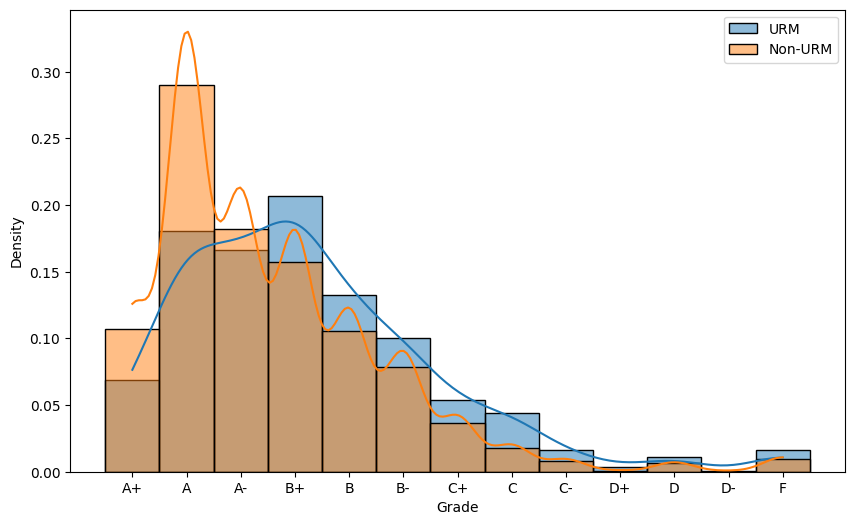

In [711]:

# Create separate dataframes for URM and non-URM students
data_URM = data100_final[data100_final['URM'] == 1]
data_non_URM = data100_final[data100_final['URM'] == 0]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(data_URM, x='GradeNm', ax=ax, stat='probability', kde=True, label='URM', alpha=0.5)
sns.histplot(data_non_URM, x='GradeNm', ax=ax, stat='probability', kde=True, label='Non-URM', alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

plt.show()


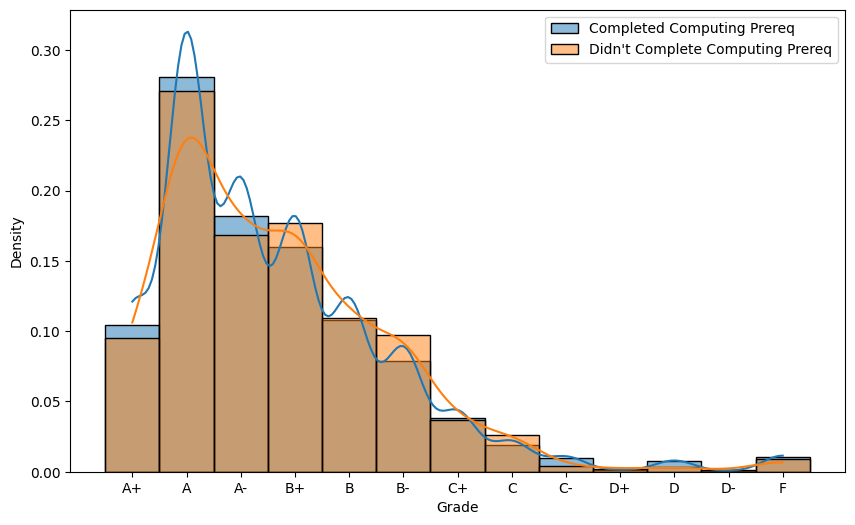

In [713]:

# Create separate dataframes for URM and non-URM students
data_cp = data100_final[data100_final['computing_req'] == 1]
data_non_cp = data100_final[data100_final['computing_req'] == 0]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(data_cp, x='GradeNm', ax=ax, stat='probability', kde=True, label='Completed Computing Prereq', alpha=0.5)
sns.histplot(data_non_cp, x='GradeNm', ax=ax, stat='probability', kde=True, label="Didn't Complete Computing Prereq", alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

plt.show()


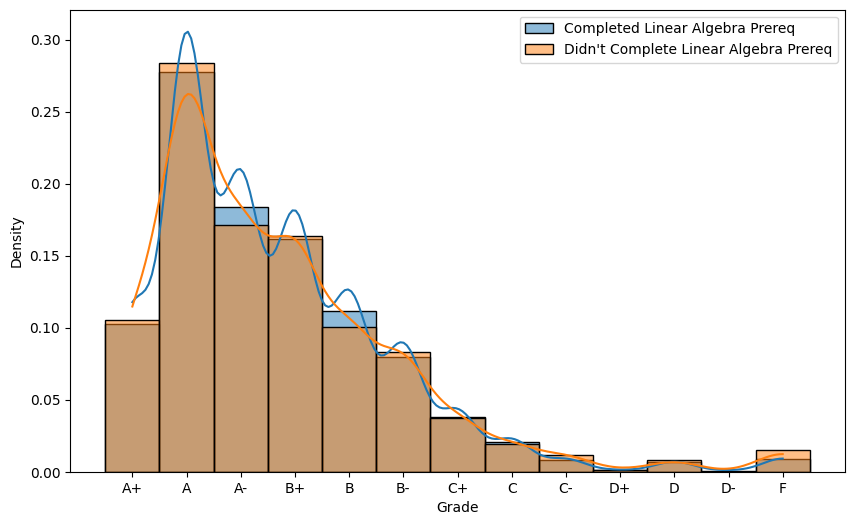

In [717]:

# Create separate dataframes for URM and non-URM students
data_math = data100_final[data100_final['math_req'] == 1]
data_non_math = data100_final[data100_final['math_req'] == 0]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(data_math, x='GradeNm', ax=ax, stat='probability', kde=True, label='Completed Linear Algebra Prereq', alpha=0.5)
sns.histplot(data_non_math, x='GradeNm', ax=ax, stat='probability', kde=True, label="Didn't Complete Linear Algebra Prereq", alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

plt.show()


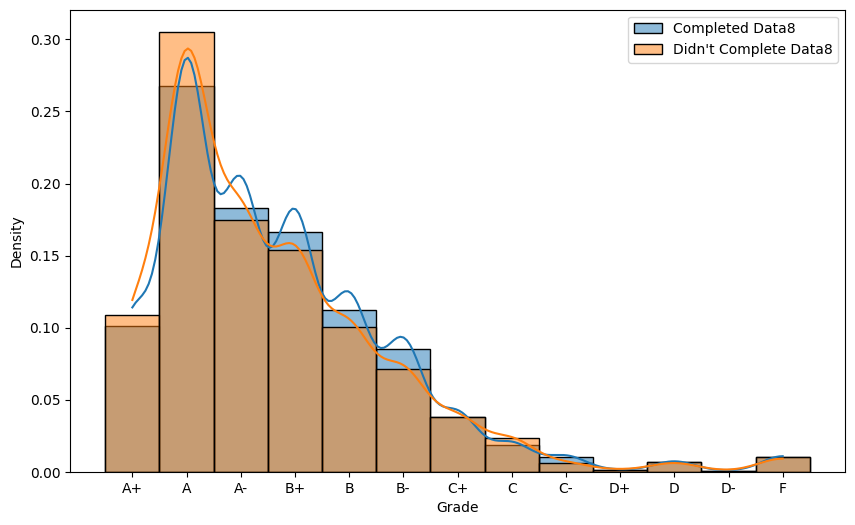

In [719]:

# Create separate dataframes for URM and non-URM students
data_d8 = data100_final[data100_final['d8_req'] == 1]
data_non_d8 = data100_final[data100_final['d8_req'] == 0]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(data_d8, x='GradeNm', ax=ax, stat='probability', kde=True, label='Completed Data8', alpha=0.5)
sns.histplot(data_non_d8, x='GradeNm', ax=ax, stat='probability', kde=True, label="Didn't Complete Data8", alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

plt.show()


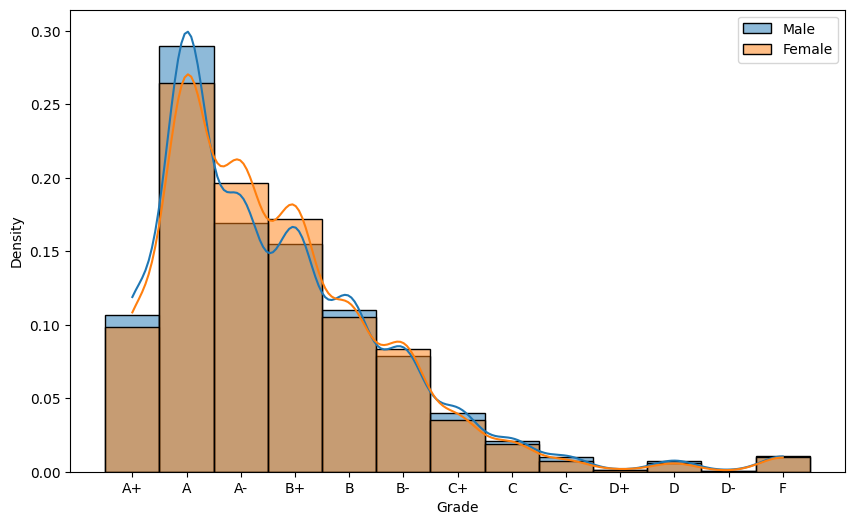

In [720]:

# Create separate dataframes for URM and non-URM students
data_m = data100_final[data100_final['gender'] == 1]
data_fm = data100_final[data100_final['gender'] == 0]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(data_m, x='GradeNm', ax=ax, stat='probability', kde=True, label='Male', alpha=0.5)
sns.histplot(data_fm, x='GradeNm', ax=ax, stat='probability', kde=True, label="Female", alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

plt.show()


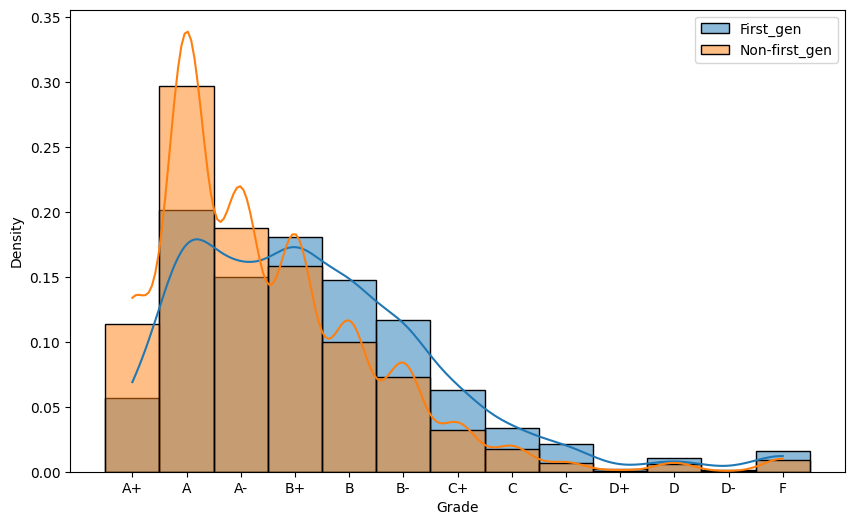

In [716]:

# Create separate dataframes for URM and non-URM students
data_first = data100_final[data100_final['first_gen'] == 1]
data_non_first = data100_final[data100_final['first_gen'] == 0]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(data_first, x='GradeNm', ax=ax, stat='probability', kde=True, label='First_gen', alpha=0.5)
sns.histplot(data_non_first, x='GradeNm', ax=ax, stat='probability', kde=True, label='Non-first_gen', alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

plt.show()


In [199]:
## distribution within each letter grade

In [351]:
## Grouping students

In [354]:
# Define the conditions and corresponding values for the new column
conditions = [
    (data100['Computer Science 61A'] == 1) & (data100['Mathematics 54'] == 1) & (data100['Data C8'] == 1),
    (data100['Computer Science 88'] == 1) & (data100['Mathematics 54'] == 1) & (data100['Data C8'] == 1),
    
]
values = [1, 2]

# Create the new column using np.select
data100['group'] = np.select(conditions, values, default=0)

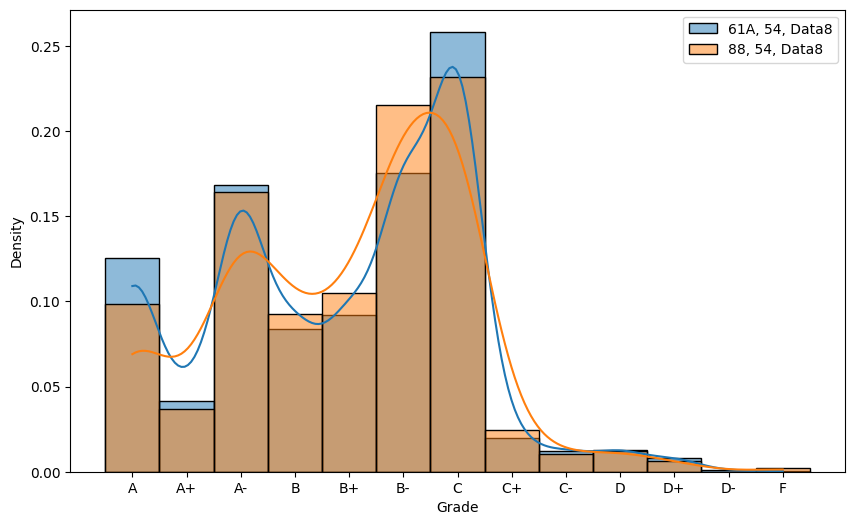

In [359]:
# Create separate dataframes for URM and non-URM students
group1 = data100[data100['group'] == 1]
group2 = data100[data100['group'] == 2]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions
sns.histplot(group1, x='GradeNm', ax=ax, stat='probability', kde=True, label='61A, 54, Data8', alpha=0.5)
sns.histplot(group2, x='GradeNm', ax=ax, stat='probability', kde=True, label='88, 54, Data8', alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('Grade')
ax.set_ylabel('Density')

# Set the x-axis ticks to show all possible grades
ax.set_xticks(range(len(data100_final['GradeNm'].unique())))
ax.set_xticklabels(sorted(data100_final['GradeNm'].unique()))

plt.show()
